# Investigation Recurrent Neural Network Models

In [10]:
# imports
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from pylab import rcParams
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

rcParams['figure.figsize'] = 15, 8

Data Preparation

In [11]:
%matplotlib inline

# data preparation
raw_data = pd.read_csv(
    "air_data_master.csv",
    parse_dates=['stime'],
    index_col = "stime",
).sort_index()

# clean data
raw_data.dropna(axis="rows", how="any", inplace=True)

# summarize data
raw_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
lat,23771.0,3.653652e+01,3.912451e+00,27.599444,3.463782e+01,3.698512e+01,3.939984e+01,4.437306e+01
lon,23771.0,-1.032576e+02,1.558227e+01,-121.731369,-1.177151e+02,-1.065852e+02,-9.483931e+01,-7.141746e+01
RH,23771.0,4.228679e+01,2.093417e+01,3.600000,2.520000e+01,4.080000e+01,5.780000e+01,1.000000e+02
UGRD,23771.0,1.269503e+00,2.699543e+00,-9.157288,-4.813247e-01,1.081478e+00,2.863122e+00,1.531967e+01
VGRD,23771.0,4.571020e-01,2.794600e+00,-16.077074,-1.333118e+00,3.165779e-01,2.201045e+00,1.325150e+01
HPBL,23771.0,1.139366e+03,8.514844e+02,19.441486,4.280526e+02,1.023972e+03,1.632405e+03,4.843839e+03
TMP,23771.0,2.942138e+02,9.396759e+00,252.974610,2.882634e+02,2.953329e+02,3.013562e+02,3.175666e+02
goes_measurement,23771.0,3.470733e-01,5.041375e-01,-0.050000,8.701269e-02,2.083822e-01,4.157892e-01,4.999973e+00
wind_direction,23771.0,1.929139e+02,8.352944e+01,0.052166,1.389751e+02,1.919345e+02,2.570906e+02,3.599970e+02
wind_speed,23771.0,3.530506e+00,2.110208e+00,0.024770,1.961734e+00,3.164643e+00,4.726928e+00,1.742862e+01


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


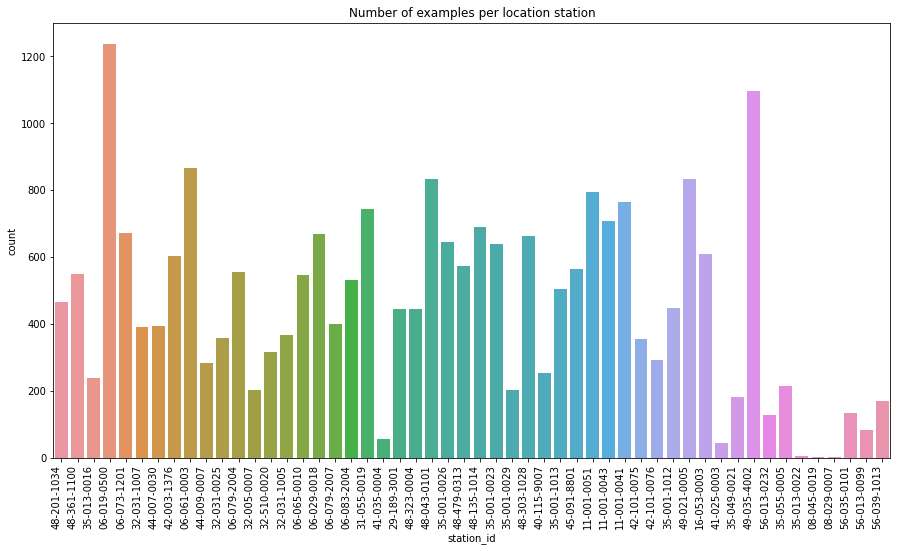

In [12]:
# check number of exampels per category
plt.figure(figsize=(15,8))
chart = sns.countplot(raw_data.station_id)
plt.title("Number of examples per location station")
chart.set_xticklabels(chart.get_xticklabels(), rotation = 90, horizontalalignment= 'right')
plt.show()

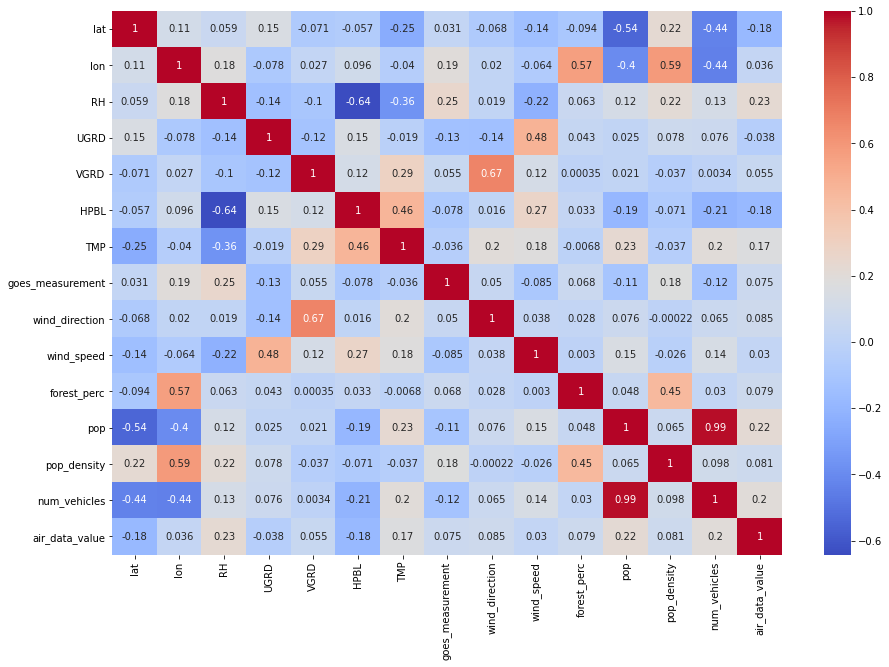

In [13]:
#check Pearson's correlation coeffcient
plt.figure(figsize=(15, 10))
sns.heatmap(raw_data.corr(),cmap='coolwarm',annot = True)
plt.show()

In [14]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

# station_id is a string; VGRD and UGRD are vectors used in calculating
# Wind speed and direction
data_part = raw_data.drop(['station_id', 'pop', 'forest_perc', 'pop',
                           'pop_density', 'num_vehicles', 'UGRD', 'VGRD'], axis=1)

# select 5 best features                         
KBest = SelectKBest(score_func = mutual_info_regression, k = 7)
KBest = KBest.fit(data_part.drop(['air_data_value'], axis=1), data_part[['air_data_value']])
cols = KBest.get_support(indices=True)
feature_cols = data_part.columns[cols].to_list()
print(feature_cols)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['lat', 'lon', 'RH', 'HPBL', 'TMP', 'goes_measurement', 'wind_direction']


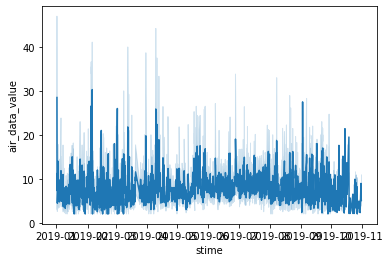

In [15]:
# plot to get insight
sns.lineplot(x=raw_data.index, y='air_data_value', data=data_part)

In [16]:
# additive decomposition of the data
# additive = seasonal_decompose(df, model='additive', freq=TIME_STEPS)
#additive.plot().suptitle('Additive Decompose', fontsize=0)

#additive.trend.plot(figsize=(20, 10))

In [17]:
# functions
def plot_predictions(fig, y_test, y_pred):
  plt.plot(y_test, marker='.', label='true')
  plt.plot(y_pred, 'r', marker='.', label='predicted')
  plt.legend()
  plt.title('Air Data Value Predictions')

def create_dataset(X, y, time_steps=2):
  Xs, ys = [], []
  for i in range(len(X) - time_steps - 1):
    v = X.iloc[i: (i + time_steps)].to_numpy()
    Xs.append(v)
    ys.append(y.iloc[i + time_steps + 1])
  return np.array(Xs), np.array(ys)

In [18]:
feature_cols.append('air_data_value')
df = raw_data[feature_cols]

TIME_STEPS = 24     # divide data on daily basis

# calculate data split sizes
train_size_frac = 0.8
train_size = int(len(df) * train_size_frac)
test_size = len(df) - train_size

# split data into training and test sets
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]

# scale and convert data only using taining 
base_columns = train.columns[:-1]
label_column = train.columns[-1]

base_transformer = MinMaxScaler(feature_range=(-1, 1))
base_transformer = base_transformer.fit(train[base_columns].to_numpy())
train.loc[:, base_columns] = base_transformer.transform(train[base_columns].to_numpy())
test.loc[:, base_columns] = base_transformer.transform(test[base_columns].to_numpy())


# for air data value
label_column_transformer = MinMaxScaler(feature_range=(-1, 1))
label_column_transformer = label_column_transformer.fit(
    train[label_column].to_numpy().reshape(-1, 1))
train[label_column] = label_column_transformer.transform(
    train[label_column].to_numpy().reshape(-1, 1))
test[label_column] = label_column_transformer.transform(
    test[label_column].to_numpy().reshape(-1, 1))


# create data using time  steps 
X_train, y_train = create_dataset(
    train[train.columns[:-1]], train.air_data_value, time_steps=TIME_STEPS)
X_test, y_test = create_dataset(
    test[test.columns[:-1]], test.air_data_value, TIME_STEPS)

print(X_train.shape) # [samples, time_steps, n_features]     

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/p

(18991, 24, 7)


### Training

In [30]:

def train(model, epochs=20, batch_size=32, loss='mse', 
          optimizer=tf.optimizers.RMSprop(1e-2)):
  earlystop_callback = tf.keras.callbacks.EarlyStopping(
      monitor='val_loss', patience=10)

  #compile model
  model.compile(
      loss=loss,
      optimizer=optimizer)

  #fit model
  history = model.fit(
      X_train, y_train,
      epochs = epochs,
      batch_size = batch_size,
      validation_split=0.1,
      shuffle= False,
      callbacks=[earlystop_callback],
      verbose = 1
  ) 

  return history

def validate(model):
  #evaluate model on testing data
  y_pred = model.predict(X_test)
  y_test_inv = label_column_transformer.inverse_transform(y_test.reshape(1,-1))
  y_pred_inv = label_column_transformer.inverse_transform(y_pred)

  f2 = plt.figure()
  plot_predictions(f2, y_test_inv.flatten(), y_pred_inv.flatten())

  #print r2
  print("\n")
  print("R2: ", metrics.r2_score(y_test, y_pred))
  print("MAE: ", metrics.mean_absolute_error(y_test, y_pred))
  print("MSE: ", metrics.mean_squared_error(y_test, y_pred))

## LSTM

In [31]:
dropout_rate=0.2

#create model
lstm_model = tf.keras.Sequential([
                               tf.keras.layers.Bidirectional(
                                   tf.keras.layers.LSTM(
                                       64,
                                       input_shape = (X_train.shape[1], 
                                                      X_train.shape[2]))),
                               tf.keras.layers.Dropout(rate = dropout_rate),
                               tf.keras.layers.Dense(1)
                               ])
lstm_model.build(X_train.shape)
print(lstm_model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (18991, 128)              36864     
_________________________________________________________________
dropout_3 (Dropout)          (18991, 128)              0         
_________________________________________________________________
dense_6 (Dense)              (18991, 1)                129       
Total params: 36,993
Trainable params: 36,993
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/20
535/535 [==============================] - 4s 8ms/step - loss: 0.0587 - val_loss: 0.0358
Epoch 2/20
535/535 [==============================] - 4s 7ms/step - loss: 0.0217 - val_loss: 0.0340
Epoch 3/20
535/535 [==============================] - 4s 7ms/step - loss: 0.0206 - val_loss: 0.0238
Epoch 4/20
535/535 [==============================] - 4s 7ms/step - loss: 0.0204 - val_loss: 0.0218
Epoch 5/20
535/535 [==============================] - 4s 7ms/step - loss: 0.0202 - val_loss: 0.0214
Epoch 6/20
535/535 [==============================] - 4s 7ms/step - loss: 0.0202 - val_loss: 0.0211
Epoch 7/20
535/535 [==============================] - 4s 7ms/step - loss: 0.0202 - val_loss: 0.0205
Epoch 8/20
535/535 [==============================] - 4s 7ms/step - loss: 0.0202 - val_loss: 0.0212
Epoch 9/20
535/535 [==============================] - 4s 7ms/step - loss: 0.0202 - val_loss: 0.0213
Epoch 10/20
535/535 [==============================] - 4s 7ms/step - loss: 0.0202 - val_loss: 0.0213

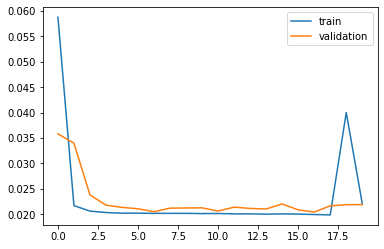

In [32]:
%matplotlib inline

# train
history = train(lstm_model)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label = 'validation')
plt.legend()



R2:  -0.17075733178327024
MAE:  0.08182750568009413
MSE:  0.012732777921886883


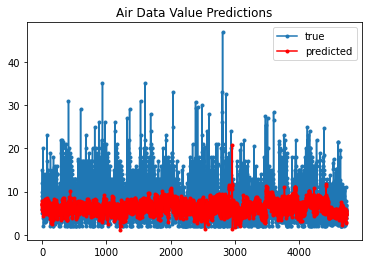

In [33]:
validate(lstm_model)

## MLP

In [34]:
mlp_model = tf.keras.Sequential([
                                # Shape: (time, features) => (time*features)
                                tf.keras.layers.Flatten(),
                                tf.keras.layers.Dense(units=128, activation='relu'),
                                 tf.keras.layers.Dropout(rate = dropout_rate),
                                tf.keras.layers.Dense(units=128, activation='relu'),
                                tf.keras.layers.Dense(units=1),
                                ])

mlp_model.build(X_train.shape)
mlp_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (18991, 168)              0         
_________________________________________________________________
dense_7 (Dense)              (18991, 128)              21632     
_________________________________________________________________
dropout_4 (Dropout)          (18991, 128)              0         
_________________________________________________________________
dense_8 (Dense)              (18991, 128)              16512     
_________________________________________________________________
dense_9 (Dense)              (18991, 1)                129       
Total params: 38,273
Trainable params: 38,273
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
535/535 [==============================] - 1s 3ms/step - loss: 3.9209 - val_loss: 0.0234
Epoch 2/20
535/535 [==============================] - 1s 2ms/step - loss: 0.0218 - val_loss: 0.0264
Epoch 3/20
535/535 [==============================] - 1s 2ms/step - loss: 0.0206 - val_loss: 0.0205
Epoch 4/20
535/535 [==============================] - 1s 2ms/step - loss: 0.0204 - val_loss: 0.0207
Epoch 5/20
535/535 [==============================] - 1s 2ms/step - loss: 0.0205 - val_loss: 0.0207
Epoch 6/20
535/535 [==============================] - 1s 2ms/step - loss: 0.0204 - val_loss: 0.0207
Epoch 7/20
535/535 [==============================] - 1s 2ms/step - loss: 0.0204 - val_loss: 0.0207
Epoch 8/20
535/535 [==============================] - 1s 2ms/step - loss: 0.0204 - val_loss: 0.0207
Epoch 9/20
535/535 [==============================] - 1s 2ms/step - loss: 0.0204 - val_loss: 0.0207
Epoch 10/20
535/535 [==============================] - 1s 2ms/step - loss: 0.0204 - val_loss: 0.0207

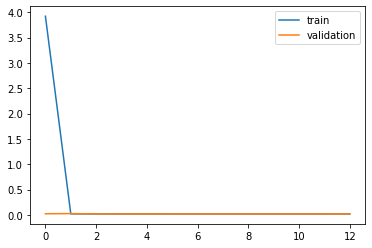

In [35]:
%matplotlib inline

# train
mlp_history = train(mlp_model)

plt.plot(mlp_history.history['loss'], label='train')
plt.plot(mlp_history.history['val_loss'], label = 'validation')
plt.legend()



R2:  -0.1863935822419378
MAE:  0.08153814330334236
MSE:  0.01290283272249869


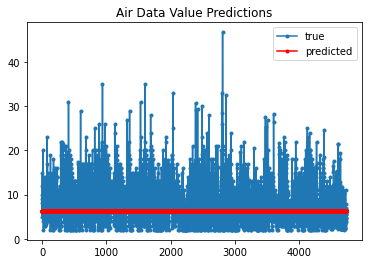

In [36]:
validate(mlp_model)

## 1-D Convolution

In [37]:
conv_model = tf.keras.Sequential([
                                tf.keras.layers.Conv1D(filters=16,
                                                      kernel_size=(6,),
                                                      activation='relu',
                                                       padding='same'),
                                tf.keras.layers.Dropout(rate = dropout_rate),
                                tf.keras.layers.Flatten(),
                                tf.keras.layers.Dense(units=64, activation='relu'),
                                tf.keras.layers.Dense(units=1),
                                ])
conv_model.build(X_train.shape)
conv_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (18991, 24, 16)           688       
_________________________________________________________________
dropout_5 (Dropout)          (18991, 24, 16)           0         
_________________________________________________________________
flatten_3 (Flatten)          (18991, 384)              0         
_________________________________________________________________
dense_10 (Dense)             (18991, 64)               24640     
_________________________________________________________________
dense_11 (Dense)             (18991, 1)                65        
Total params: 25,393
Trainable params: 25,393
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
535/535 [==============================] - 1s 3ms/step - loss: 0.5019 - val_loss: 0.0352
Epoch 2/20
535/535 [==============================] - 1s 3ms/step - loss: 0.0206 - val_loss: 0.0262
Epoch 3/20
535/535 [==============================] - 1s 3ms/step - loss: 0.0205 - val_loss: 0.0257
Epoch 4/20
535/535 [==============================] - 1s 3ms/step - loss: 0.0204 - val_loss: 0.0238
Epoch 5/20
535/535 [==============================] - 1s 3ms/step - loss: 0.0204 - val_loss: 0.0238
Epoch 6/20
535/535 [==============================] - 1s 3ms/step - loss: 0.0204 - val_loss: 0.0234
Epoch 7/20
535/535 [==============================] - 1s 3ms/step - loss: 0.0204 - val_loss: 0.0220
Epoch 8/20
535/535 [==============================] - 1s 3ms/step - loss: 0.0204 - val_loss: 0.0221
Epoch 9/20
535/535 [==============================] - 1s 3ms/step - loss: 0.0204 - val_loss: 0.0220
Epoch 10/20
535/535 [==============================] - 1s 3ms/step - loss: 0.0204 - val_loss: 0.0207

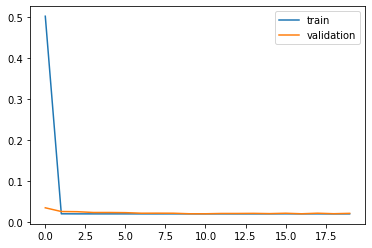

In [38]:
%matplotlib inline

# train
conv_history = train(conv_model)

plt.plot(conv_history.history['loss'], label='train')
plt.plot(conv_history.history['val_loss'], label = 'validation')
plt.legend()




R2:  -0.2148799017904819
MAE:  0.08226821337566975
MSE:  0.01321264071667204


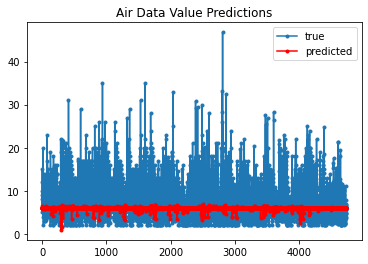

In [39]:
validate(conv_model)

## Save Best Model

In [40]:
import os
# save model
#my_model_path = os.path.dirname('saved_model/my_model')
#model.save(my_model_path)